---------
# Recovering secret in SSTIC 2019 challenge SCA 
-------

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import numpy as np

In [6]:
trace_npz = np.load('../SideSCA-Traces-Public/RSA_SSTIC_power_consumption.npz')
trace_lst = trace_npz.files

In [7]:
print(trace_lst)

['arr_0']


In [8]:
trace = trace_npz['arr_0']
len(trace)

1842128

In [9]:
trace[0:20]

array([ 0.00387928,  0.05724333, -0.01318807, -0.02729493, -0.02348536,
        0.0465676 ,  0.04035217, -0.01577941, -0.02894039,  0.01174628,
        0.07196697,  0.03027694,  0.00464222,  0.02307723,  0.00593505,
       -0.01687661,  0.05888884, -0.06209962,  0.01097336,  0.01333775])

## Plot the trace

In [10]:
import matplotlib.pyplot as plt

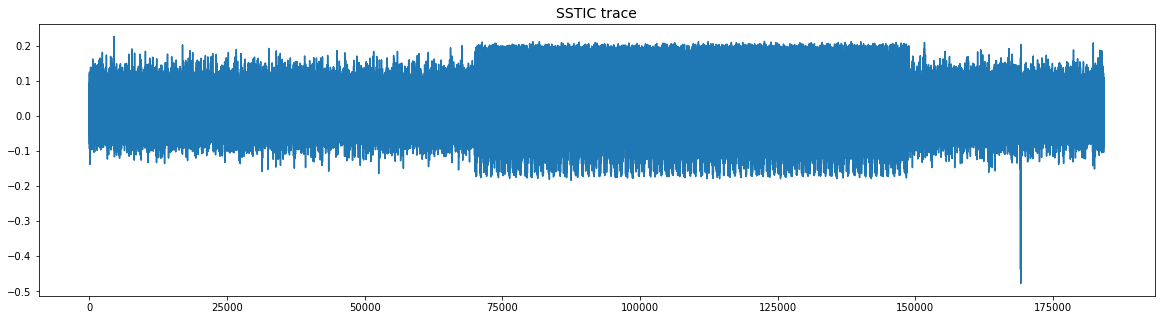

In [11]:
plt.rcParams['figure.figsize'] = 20, 5
plt.title('SSTIC trace', fontsize=14)    
#plt.plot(trace[::10], '.')
plt.plot(trace[::10])
plt.show()

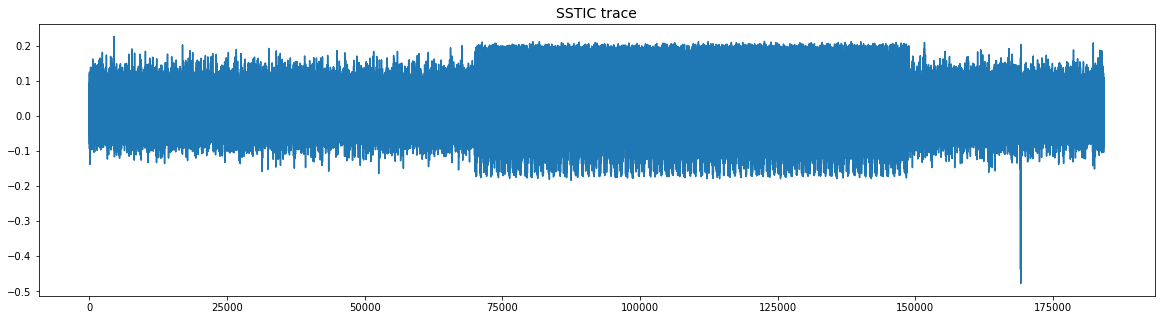

In [12]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 5
plt.title('SSTIC trace', fontsize=14)    
#plt.plot(trace[::10], '.')
plt.plot(trace[::10])
plt.show()

In [13]:
trace_expo = trace[650000:1600000]

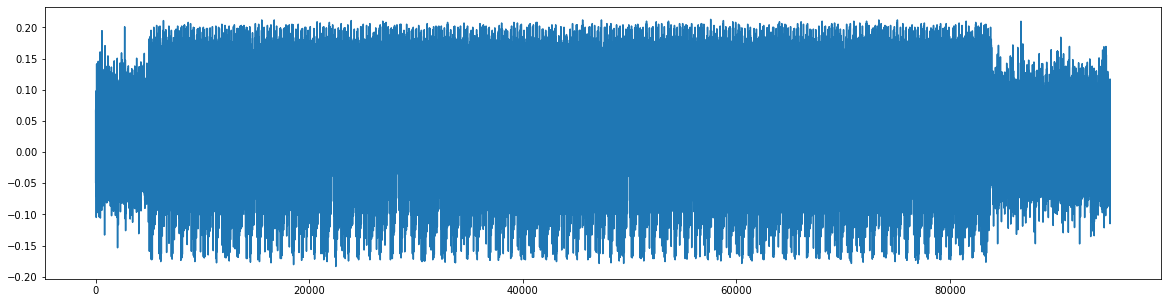

In [14]:
plt.plot(trace_expo[::10])
plt.show()

In [15]:
import scared

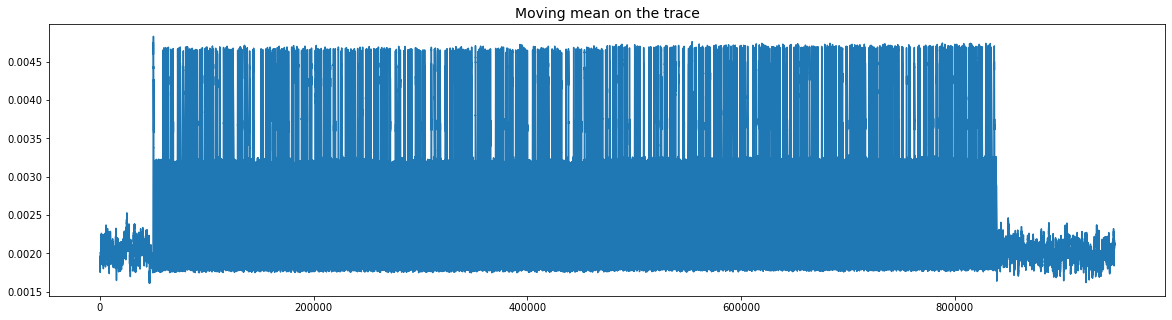

In [16]:
period = 500
plt.title('Moving mean on the trace', fontsize=14)    
trace_mean = scared.signal_processing.moving_var(trace_expo, period).T
plt.plot(trace_mean)
plt.show()

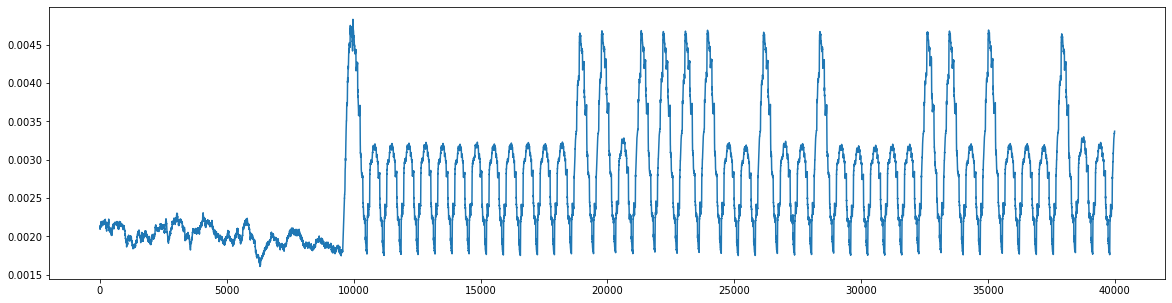

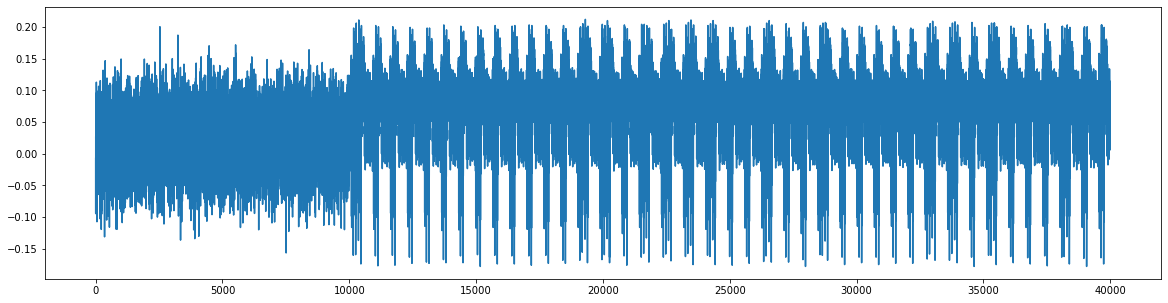

In [17]:
plt.plot(trace_mean[40000:80000])
plt.show()
plt.plot(trace_expo[40000:80000])
plt.show()

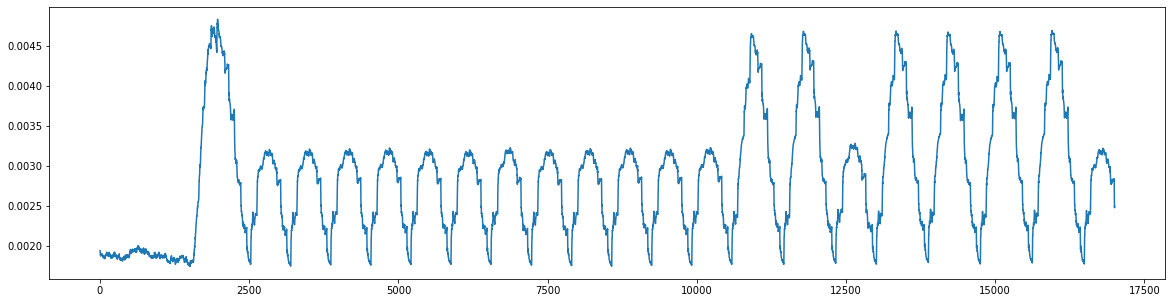

In [18]:
plt.plot(trace_mean[48000:65000])
plt.show()

In [19]:
from scared.signal_processing import pattern_detection, peaks_detection

[ 1970  2838  3509  4180  4851  5522  6193  6875  7544  8215  8886  9557
 10228 10916 11787 12651 13338 14209 15080 15951 16805]
21


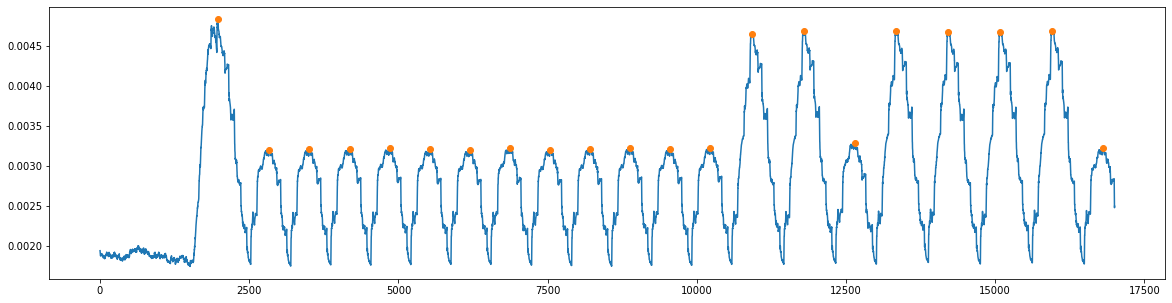

In [20]:
trace_num = trace_mean[48000:65000]
P = peaks_detection.find_peaks(trace_num, 500, 0.0030)
print(P)
print(len(P))
plt.plot(trace_num)
plt.plot(P, trace_num[P], 'C1o')
plt.show()

[ 49970  50838  51509 ... 836892 837746 838427]
Number of peaks found = 1024


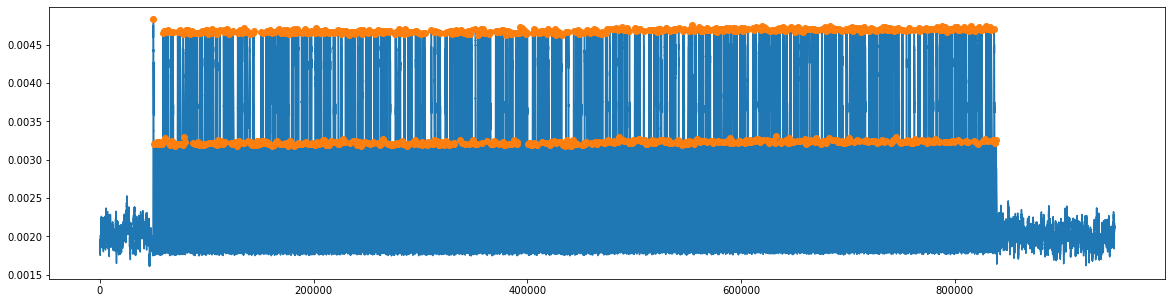

In [21]:
trace_num = trace_mean
P = peaks_detection.find_peaks(trace_num, 500, 0.0030)
print(P)
print("Number of peaks found = "+str(len(P)))
plt.plot(trace_num)
plt.plot(P, trace_num[P], 'C1o')
plt.show()

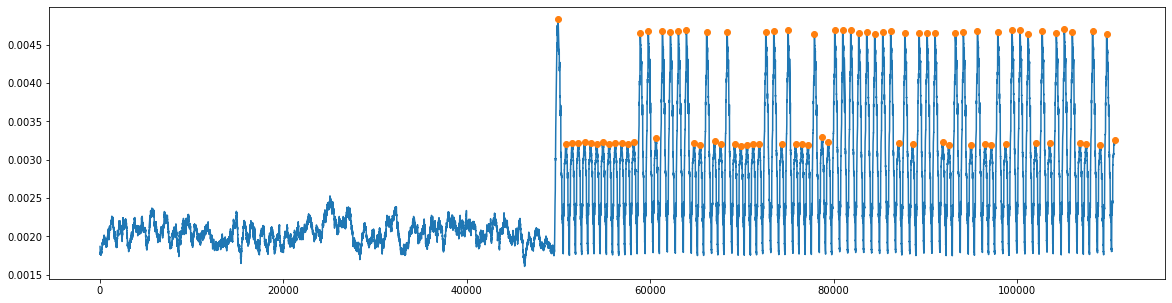

In [22]:
P1 = P[:80]
plt.plot(trace_num[:P1[-1]])
plt.plot(P1, trace_num[P1], 'o')
plt.show()

We have 1024 peaks, so not 1024+512 as we would expect from a classical Square&Multiply algorithm.

So let's suppose:
- the higher peaks are squaring+multiplication
- the lower peaks are only squaring

In [23]:
exposant_right_left = 0
exposant_left_right = 0
for i in range(len(P)):
    if (trace_num[P[i]] > 0.004): 
        exposant_right_left += pow(2, i) 
        exposant_left_right += pow(2, (len(P)-1-i))

In [24]:
print("Exponent candidate from right to left is:\n"+hex(exposant_right_left))
int.bit_length(exposant_right_left)

Exponent candidate from right to left is:
0x23d87cdf97bb95abe6273c384190c765f552ab86f6de30a8db74435c95e6e3138f54af689812d8f9359cf0f4d453a0c11ec68ce470216c09e74c8947adaf23e902415d61ddf2c0ffe459cbb40f7de42bdb7cd14093100a570e8c29819765e2d8d276f86471b52ac29aa2ce2bb72cd45006279e82bec253ae9675fe45824f6001


1022

In [25]:
print("Exponent candidate from left to right is:\n"+hex(exposant_left_right))
int.bit_length(exposant_left_right)

Exponent candidate from left to right is:
0x8006f241a27fae6975ca437d4179e4600a2b34edd47345594354ad8e261f6e4b1b47a6e981943170ea5008c9028b3edbd427bef02dd39a27ff034fbb86ba824097c4f5b5e29132e79036840e273163788305ca2b2f0f39ac9f1b481916f52af1c8c767a93ac22edb150c7b6f61d54aafa6e309821c3ce467d5a9dde9fb3e1bc4


1024

In [26]:
#modulus N from SSTIC reverse is
N = 0xD072DD3F639C2D0E1FF69AB965782F668D7BFFAC766AEEAB5DA84AE373F8C0DCAA18C6BDCBD551BB012F42AFC0F3FC4AAD438C212FF8A4E597053CD60B54AC484714FBAE059C97F8138CEDE9A80060D3C816288FF2C77D82081E586F73EE78E06F69D7D57596ACF1959D6F3ED00D2CDDB11DECF25A379DEF4DCE3B264AD7E819

In [27]:
int.bit_length(N)

1024

## Tests the exponent recovered

In [28]:
import random

In [29]:
def test_exponent_found(e, d):
    plaintext = random.randint(1, 2**1021)
    ciphertext = pow(plaintext, e, N)
    recovered_ptxt = pow(ciphertext, d, N)
    if (recovered_ptxt==plaintext): 
        print("found - success")
        bool_answer = True
    else:
        print("not found - fail")
        bool_answer = False
        
    return bool_answer

In [30]:
e = 3
result = test_exponent_found(e, exposant_left_right)

not found - fail


In [31]:
e = 2**16+1
result = test_exponent_found(e, exposant_left_right)

not found - fail


In [32]:
e = 3
result = test_exponent_found(e, exposant_right_left)

not found - fail


In [33]:
e = 2**16+1
result = test_exponent_found(e, exposant_right_left)

found - success


# Conclusion
#### Exponent is recovered from the side-channel trace given in this challenge.

In [34]:
print("Exponent recovered is:\n"+hex(exposant_right_left))

Exponent recovered is:
0x23d87cdf97bb95abe6273c384190c765f552ab86f6de30a8db74435c95e6e3138f54af689812d8f9359cf0f4d453a0c11ec68ce470216c09e74c8947adaf23e902415d61ddf2c0ffe459cbb40f7de42bdb7cd14093100a570e8c29819765e2d8d276f86471b52ac29aa2ce2bb72cd45006279e82bec253ae9675fe45824f6001


# Recovering p and q primes.

In [38]:
import aLibrary.rsa_prime_factors_recovery as pfr

In [39]:
factor = pfr.prime_factor_recovery(e,N,exposant_right_left)

In [40]:
factor.run()

'success'

In [41]:
factor.print_result()

prime p found is: 0xd3e9bb53e6643b63e3455a47af385334d7206bfd1ab17d4e19335abfa86551a62290dc476616a01fb9d60fd0844449d0d9f03adac53a049b7345ce706f760219

prime q found is: 0xfbd0a045e00ed117d0a7e3467e4d661ff89f4fb0ddcbd39c5b83a2bda17aa7c78f0b586d87b7bcaf9283586097470f01e1971436a0a4517b3d0ee1c010c9d601


In [42]:
factor.check()

'Factorization check ok.'